# Advanced GIS Lab 1

### Import shapefiles and organize them inside a geopackage
---

In [1]:
import pathlib
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Establish working directory paths
PATH = pathlib.Path().resolve()
DATA_DIR = PATH / 'data'
OUTPUT = PATH / 'output'

In [13]:
# Delete existing GeoPackage to avoid duplicates
gpkg_path = OUTPUT / 'States.gpkg'
if gpkg_path.exists():
    print("Deleting existing GeoPackage to avoid duplicates...")
    gpkg_path.unlink()

In [14]:
#Select all shapefiles
gdf = {}
shp_files = DATA_DIR.glob('*.shp')
for file in shp_files:
    name = file.stem
    gdf[name] = gpd.read_file(file)
    print(name)

Freeways
States
Large_Cities


In [15]:
#Loop through shapefiles and import them into geopackage
for layer in enumerate(gdf):
    if layer[0] == 0:
        gdf[layer[1]].to_file(OUTPUT / 'States.gpkg', layer=layer[1])
    else:
        gdf[layer[1]].to_file(OUTPUT / 'States.gpkg', layer=layer[1], mode='a')

## Establish Variables for Mapping from Geopackage

In [16]:
STATES_GPKG = OUTPUT / 'States.gpkg'
states = gpd.read_file(STATES_GPKG, layer='States')
freeways = gpd.read_file(STATES_GPKG, layer='Freeways')
cities = gpd.read_file(STATES_GPKG, layer='Large_Cities')

#Filter states geodataframes to lower 48
states = states[~states['STATE_NAME'].isin(['Hawaii', 'Alaska'])]
freeways = freeways[~freeways['CLASS'].isin(['N'])]

#use states layer as filiter for freeways and cities extent
sel_fw = freeways.intersects(states.union_all())
sel_c = cities.intersects(states.union_all())
freeways = freeways[sel_fw]
cities = cities[sel_c]
cities.columns

Index(['ObjectID', 'NAME', 'CLASS', 'ST', 'STFIPS', 'PLACEFIP', 'CAPITAL',
       'AREALAND', 'AREAWATER', 'POP_CLASS', 'POP2000', 'WHITE', 'BLACK',
       'AMERI_ES', 'ASIAN', 'HAWN_PI', 'OTHER', 'MULT_RACE', 'HISPANIC',
       'MALES', 'FEMALES', 'AGE_UNDER5', 'AGE_5_17', 'AGE_18_21', 'AGE_22_29',
       'AGE_30_39', 'AGE_40_49', 'AGE_50_64', 'AGE_65_UP', 'MED_AGE',
       'MED_AGE_M', 'MED_AGE_F', 'HOUSEHOLDS', 'AVE_HH_SZ', 'HSEHLD_1_M',
       'HSEHLD_1_F', 'MARHH_CHD', 'MARHH_NO_C', 'MHH_CHILD', 'FHH_CHILD',
       'FAMILIES', 'AVE_FAM_SZ', 'HSE_UNITS', 'VACANT', 'OWNER_OCC',
       'RENTER_OCC', 'geometry'],
      dtype='object')

## Create Map

/tmp/ipykernel_1681075/2103814387.py:3: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  base = states.plot(figsize=(20, 20), color='None', edgecolor='grey', column='STATE_NAME', zorder=1)


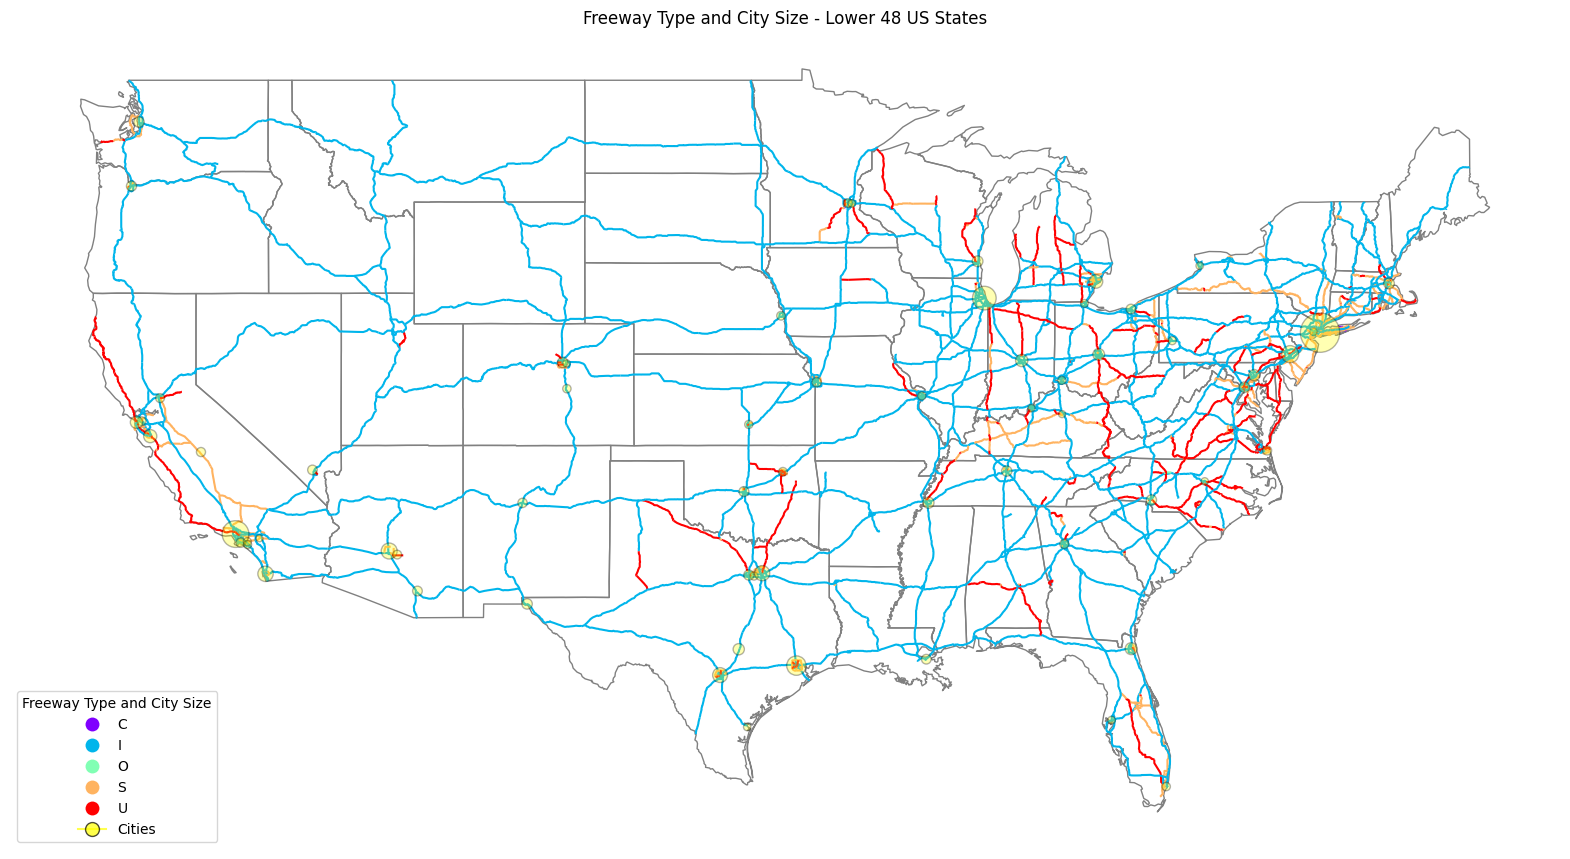

In [17]:
import matplotlib.lines as mlines
import numpy as np
base = states.plot(figsize=(20, 20), color='None', edgecolor='grey', column='STATE_NAME', zorder=1)

freeways_plot = freeways.plot(ax=base, column='CLASS', cmap='rainbow', zorder=2, legend=True)
cities.plot(ax=base, markersize=(cities['POP2000'] / 10000), color='yellow', edgecolor='black', alpha=0.3, zorder=3)

#Had to look up how to set legend for multiple layers...

# Get the freeway legend and remove it temporarily
freeway_legend = base.legend_
base.legend_ = None  # Remove from plot

# Create city handle
city_handle = mlines.Line2D([], [], color='yellow', marker='o', markersize=10, 
                           label='Cities', markeredgecolor='black', alpha=0.7)

# Combine freeway legend handles with city handle
if freeway_legend:
    all_handles = freeway_legend.legend_handles + [city_handle]
    all_labels = [t.get_text() for t in freeway_legend.get_texts()] + ['Cities']
    
    # Create new combined legend
    base.legend(handles=all_handles, labels=all_labels, loc='lower left', title='Freeway Type and City Size')
    
base.set_title("Freeway Type and City Size - Lower 48 US States")
base.set_axis_off()
plt.savefig(OUTPUT / 'States_Lab1.png', dpi=300)

# Lab 2 - Quantitative Rendering

### Convert to Projected Coordinate System

In [18]:
states.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<Axes: >

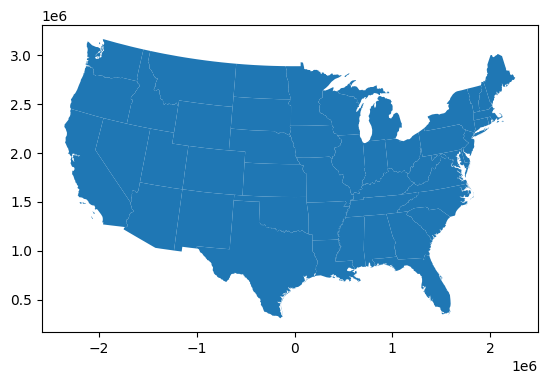

In [19]:
#Convert to Albers Equal Area Conic
#The CRS code is EPSG:5070 

states = states.to_crs(5070)
states.plot()

In [72]:
#Haven't yet found an equivalent to the metadata explorer in Pro
#Seems very involved processing from shp files data
#!Area to work on solution and workflow!
cities.describe()

,ObjectID,AREALAND,AREAWATER,POP_CLASS,POP2000,WHITE,BLACK,AMERI_ES,ASIAN,HAWN_PI,...,MARHH_CHD,MARHH_NO_C,MHH_CHILD,FHH_CHILD,FAMILIES,AVE_FAM_SZ,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC
count,65.000000,65.000000,65.000000,65.000000,6.500000e+01,6.500000e+01,6.500000e+01,65.000000,65.000000,65.000000,...,65.000000,65.000000,65.000000,65.000000,6.500000e+01,65.000000,6.500000e+01,65.000000,65.000000,6.500000e+01
mean,1487.707692,186.211785,26.993477,8.584615,7.526854e+05,3.998396e+05,1.844269e+05,5512.430769,48858.153846,1049.892308,...,52693.400000,58170.953846,6122.400000,27186.646154,1.723185e+05,3.232923,3.072457e+05,21779.323077,134413.938462,1.510525e+05
std,956.592696,154.710060,59.841244,0.726557,1.082463e+06,4.867234e+05,3.108671e+05,7294.975131,112547.207552,1489.507523,...,74669.630552,78225.219943,7723.660074,40995.016757,2.472938e+05,0.269622,4.255966e+05,25853.148632,133337.513233,2.745127e+05
min,87.000000,23.797000,0.051000,8.000000,2.551660e+05,7.253700e+04,5.749000e+03,507.000000,2376.000000,76.000000,...,13684.000000,13484.000000,1577.000000,5534.000000,5.815500e+04,2.870000,7.458800e+04,1586.000000,21738.000000,3.555000e+04
25%,701.000000,77.967000,1.507000,8.000000,3.442840e+05,1.948710e+05,4.572700e+04,1713.000000,8182.000000,212.000000,...,23177.000000,26647.000000,3012.000000,12413.000000,7.737800e+04,3.070000,1.490250e+05,8993.000000,68589.000000,6.328900e+04
50%,1135.000000,135.089000,4.225000,8.000000,4.784030e+05,2.754880e+05,7.911800e+04,3140.000000,15189.000000,416.000000,...,34413.000000,41045.000000,3802.000000,16654.000000,1.125150e+05,3.190000,1.984650e+05,14985.000000,101214.000000,8.830100e+04
75%,2406.000000,249.075000,15.443000,9.000000,6.511540e+05,3.948890e+05,1.782660e+05,6472.000000,33470.000000,1067.000000,...,44268.000000,52235.000000,5355.000000,28083.000000,1.451860e+05,3.350000,2.768420e+05,25218.000000,125539.000000,1.325170e+05
max,3389.000000,757.673000,305.596000,10.000000,8.008278e+06,3.576385e+06,2.129762e+06,41289.000000,787047.000000,5915.000000,...,532402.000000,591903.000000,52854.000000,312600.000000,1.853223e+06,4.720000,3.200912e+06,179324.000000,912296.000000,2.109292e+06


### Summarize by Region

In [36]:
#Create summarize variable
region_summarized = states.groupby('SUB_REGION')
region_summarized['ObjectID'].count()

SUB_REGION
E N Cen    5
E S Cen    4
Mid Atl    3
Mtn        8
N Eng      6
Pacific    3
S Atl      9
W N Cen    7
W S Cen    4
Name: ObjectID, dtype: int64

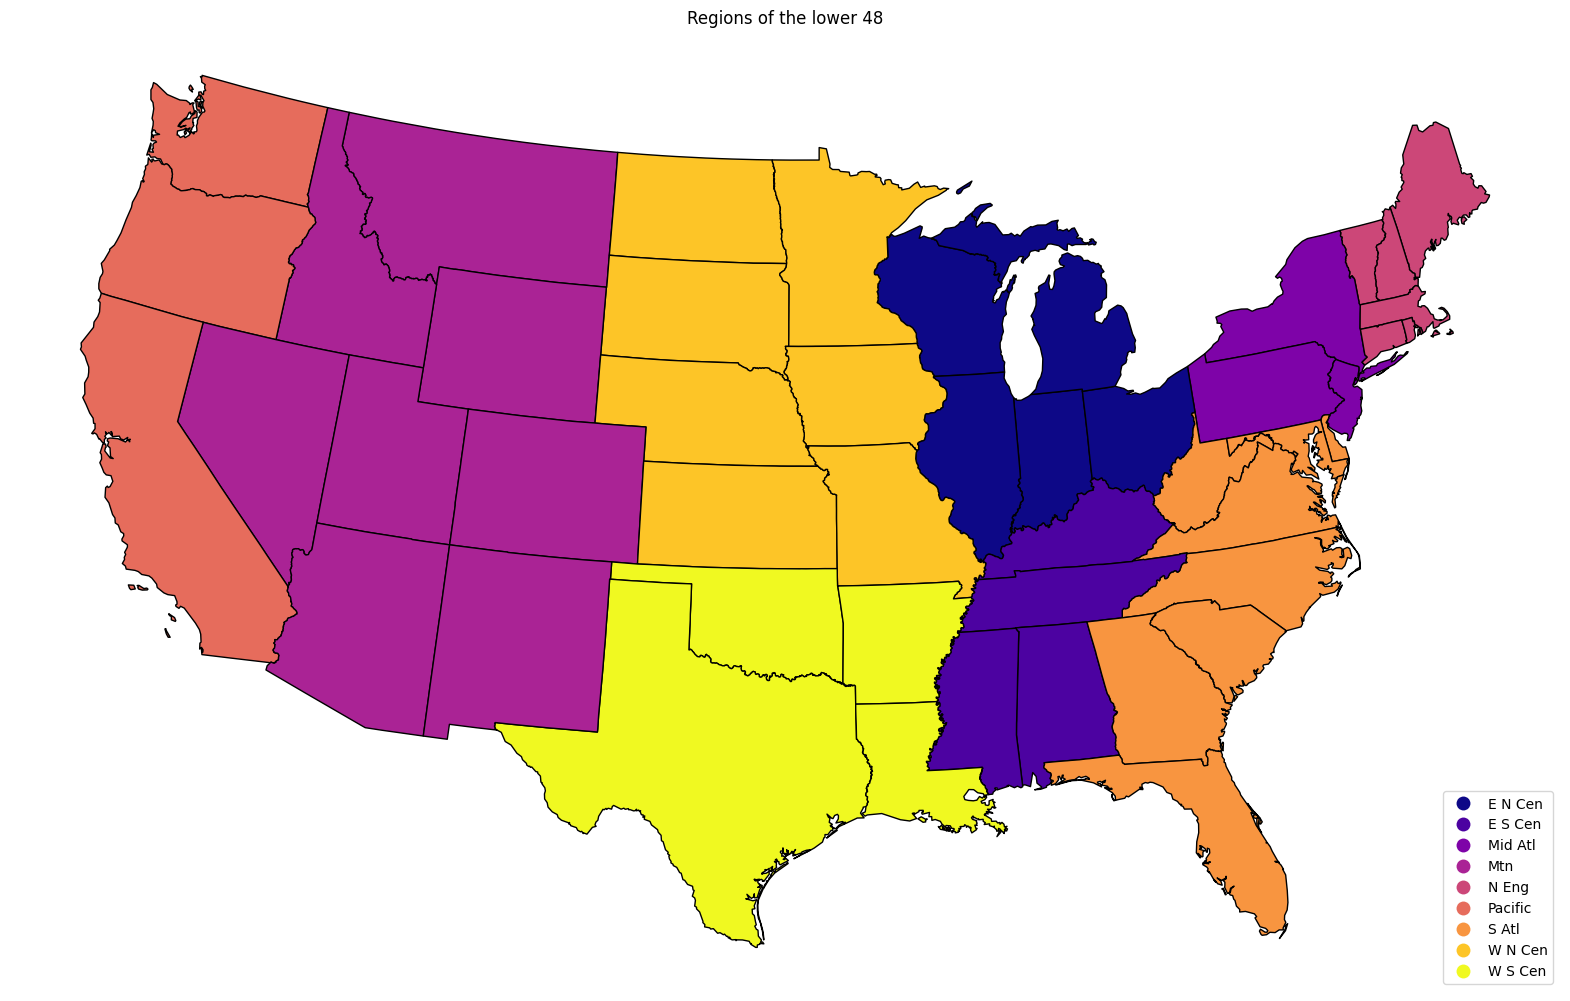

In [70]:
base = states.plot(column='SUB_REGION', cmap='plasma', edgecolor='black', figsize=(20,15), legend=True, legend_kwds={'loc':'lower right'})
base.set_axis_off()
base.set_title('Regions of the lower 48')
plt.savefig(OUTPUT / 'states_by_subregion.png', dpi=300)

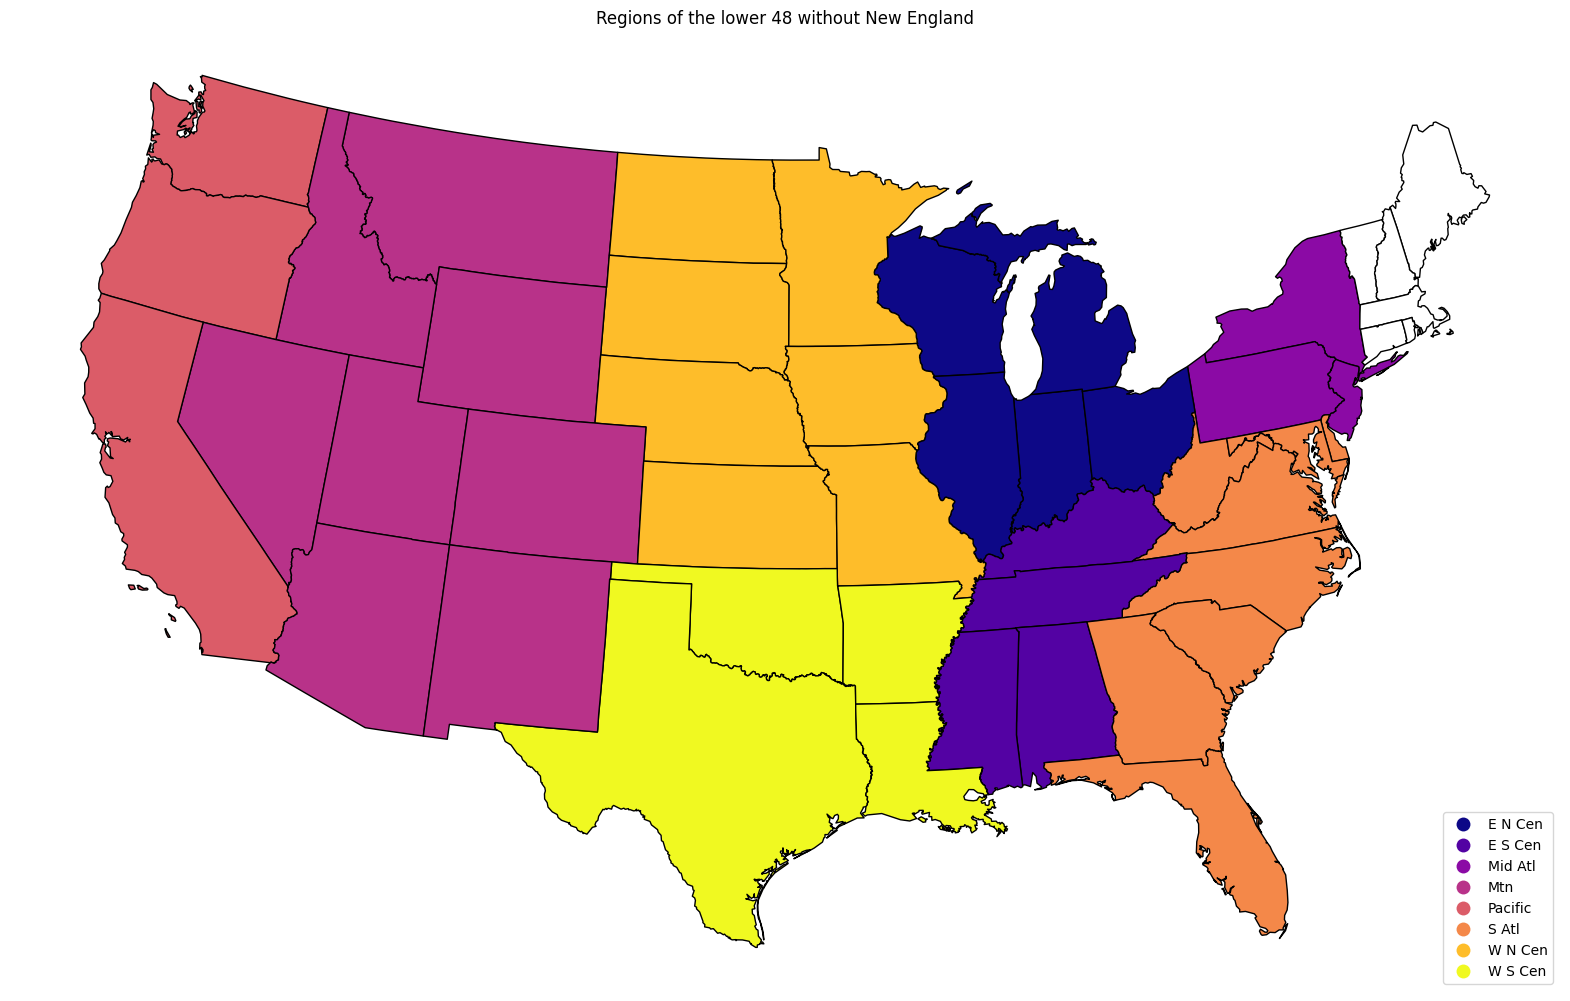

In [69]:
#Create variable without New England
sans_N_Eng = states.copy()
sans_N_Eng['SUB_REGION'] = sans_N_Eng['SUB_REGION'].replace('N Eng', np.nan)

base = sans_N_Eng.plot(column='SUB_REGION', cmap='plasma', edgecolor='black', figsize=(20,15), legend=True, legend_kwds={'loc':'lower right'})

#Plot N Eng itself outside color map
states[states['SUB_REGION'] == 'N Eng'].plot(ax=base, color='white', edgecolor='black')

base.set_axis_off()
base.set_title('Regions of the lower 48 without New England')
plt.savefig(OUTPUT / 'states_by_subregion_Sans_NE.png', dpi=300)

### Set symbology by Population Density

In [73]:
states.columns

Index(['ObjectID', 'STATE_NAME', 'STATE_FIPS', 'SUB_REGION', 'STATE_ABBR',
       'POP2000', 'POP2004', 'POP00_SQMI', 'POP04_SQMI', 'WHITE', 'BLACK',
       'AMERI_ES', 'ASIAN', 'HAWN_PI', 'OTHER', 'MULT_RACE', 'HISPANIC',
       'MALES', 'FEMALES', 'AGE_UNDER5', 'AGE_5_17', 'AGE_18_21', 'AGE_22_29',
       'AGE_30_39', 'AGE_40_49', 'AGE_50_64', 'AGE_65_UP', 'MED_AGE',
       'MED_AGE_M', 'MED_AGE_F', 'HOUSEHOLDS', 'AVE_HH_SZ', 'HSEHLD_1_M',
       'HSEHLD_1_F', 'MARHH_CHD', 'MARHH_NO_C', 'MHH_CHILD', 'FHH_CHILD',
       'FAMILIES', 'AVE_FAM_SZ', 'HSE_UNITS', 'VACANT', 'OWNER_OCC',
       'RENTER_OCC', 'NO_FARMS97', 'AVG_SIZE97', 'CROP_ACR97', 'AVG_SALE97',
       'SQMI', 'geometry'],
      dtype='object')

In [124]:
#Calculate population density and assign as column for plotting
states['POP_DENS'] = round(states['POP2004'] / states['SQMI'], 0)
states['POP_DENS'] = states['POP_DENS'].astype(int)
states[['STATE_NAME', 'POP_DENS']]

,STATE_NAME,POP_DENS
1,Washington,92
2,Montana,6
3,Maine,41
4,North Dakota,9
5,South Dakota,10
6,Wyoming,5
7,Wisconsin,99
8,Idaho,17
9,Vermont,66
10,Minnesota,62


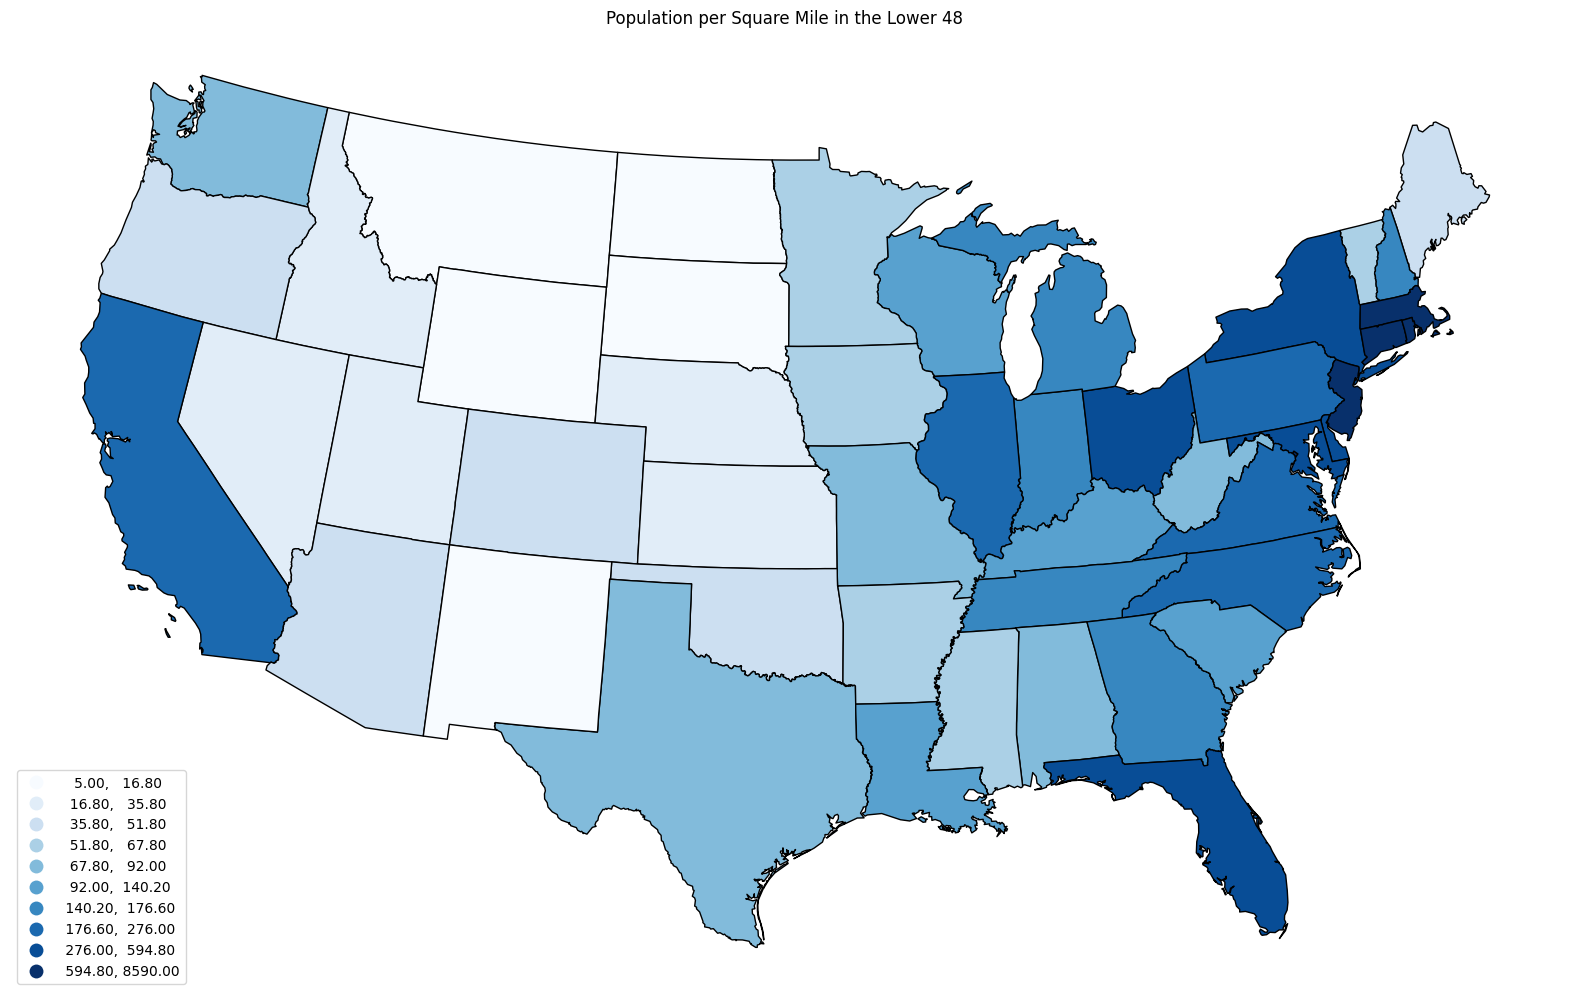

In [126]:
base = states.plot(column='POP_DENS', 
            scheme='quantiles', 
            k=10, 
            cmap='Blues',
            edgecolor = 'black',
            legend=True,
            figsize=(20, 20),
            legend_kwds = {'loc': 'lower left'}
            )
base.set_axis_off()
base.set_title('Population per Square Mile in the Lower 48')
plt.savefig(OUTPUT / 'pop_density.png', dpi=300)

### Plot map with labels

In [131]:
states[['STATE_NAME', 'HOUSEHOLDS', 'HSEHLD_1_M', 'HSEHLD_1_F', 'MARHH_NO_C']]

,STATE_NAME,HOUSEHOLDS,HSEHLD_1_M,HSEHLD_1_F,MARHH_NO_C
1,Washington,2271398,273745,320580,640359
2,Montana,358667,45992,52430,109683
3,Maine,518200,58346,81623,159385
4,North Dakota,257152,34487,40933,75431
5,South Dakota,290245,35536,44504,86243
6,Wyoming,193608,24901,26079,59183
7,Wisconsin,2084544,245851,312024,615067
8,Idaho,469645,47725,57450,144410
9,Vermont,240634,27121,35991,70506
10,Minnesota,1895127,224075,285393,540630


In [156]:
#Calculate percentage of households without children
states['pc_HH_N_C'] = round(sum([states['HSEHLD_1_M'], states['HSEHLD_1_F'], states['MARHH_NO_C']]) / states['HOUSEHOLDS'], 2)
#Convert to String and add '%' sign
states['pc_HH_N_C'] = (states['pc_HH_N_C'] * 100).astype(int).astype(str)
states['pc_HH_N_C'] = states['pc_HH_N_C'] + '%'
states[['STATE_NAME', 'pc_HH_N_C']]


,STATE_NAME,pc_HH_N_C
1,Washington,54%
2,Montana,57%
3,Maine,57%
4,North Dakota,59%
5,South Dakota,56%
6,Wyoming,56%
7,Wisconsin,56%
8,Idaho,53%
9,Vermont,56%
10,Minnesota,55%


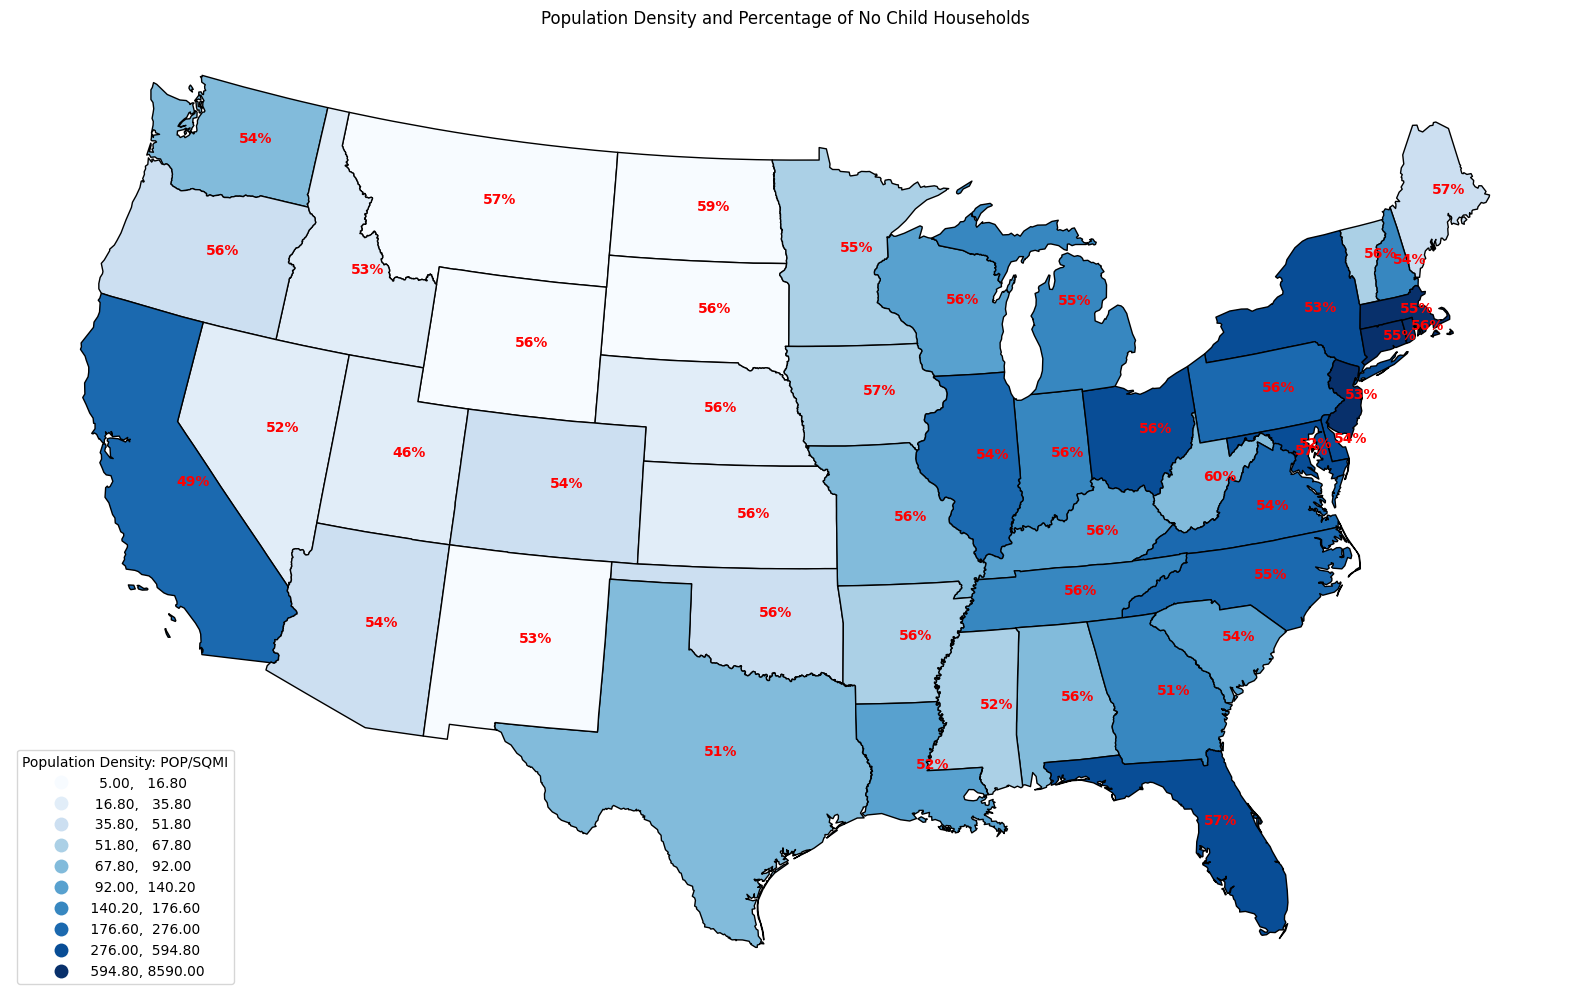

In [201]:
#plot Population density with labels of percentage on no child HHs
base = states.plot(column='POP_DENS', 
            scheme='quantiles', 
            k=10, 
            cmap='Blues',
            edgecolor = 'black',
            legend=True,
            figsize=(20, 20),
            legend_kwds = {'loc': 'lower left', 'title':'Population Density: POP/SQMI'},
            label=states['pc_HH_N_C']
            )
base.set_axis_off()
base.set_title('Population Density and Percentage of No Child Households')

#iterate though each state and set labels
for pct, geo in zip(states['pc_HH_N_C'], states['geometry']):
    loc = geo.centroid
    base.text(loc.x, loc.y, pct, c='red', weight='bold')

#Definietly want to refine positioning labels
plt.tofig(OUTPUT / 'POP_DENS_N_C.png', dpi=300)

# Future improvements
- Metadata reader workflow
- label positioning on map